In [37]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
#PROBLEM SETUP
#Give IVP  : u' = cos 2pi*t   / IC : u(0) = 0


# exact = u(t) = (1/2pi)sin2pi*t

def targetfct(x):
    return torch.cos(2*np.pi*x) 

#domain
# [0,n]
domain_muliple = 10 

#training set
 
sample_size = 100

#x_data =  torch.rand(sample_size,requires_grad = True).unsqueeze(1) :  default code
#x_data =  5* torch.rand(sample_size,requires_grad = True).unsqueeze(1)   ##caution!! gradient is not recorded when 5*, so should do like below 

x_data =  domain_muliple*torch.rand(sample_size).unsqueeze(1)
x_data.requires_grad = True
# num of iter
epoch = 40000



In [39]:
class NNforsimpleODEfoward(nn.Module):
    def __init__(self):
        super(NNforsimpleODEfoward,self).__init__()     # execute all method of mother class, i.e) nn.Module       
        self.hiddenlayer = nn.Sequential(  ## input tensor should be of size [n,1], procedure of dimension until output will be [n,1] -> [n,100] -> [n,1]
            nn.Linear(1, 100),              # if data is 1-d, n would be # of train data
            nn.Tanh(),                      # if data is higher than 2-D, it should be concatonated to squeeze
            nn.Linear(100, 1),
        )

    def forward(self, x):
        output = self.hiddenlayer(x)
        return output

def ODE_Loss(x,NN):      
    u = NN.forward(x)
    u_x = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u), create_graph = True)[0] # get derivate u at x 
    #grad_outputs should be a sequence of length matching output(u in this code) containing the “vector” in vector-Jacobian product, usually the pre-computed gradients w.r.t. each of the outputs.
    
    #loss of ode
    loss = u_x - targetfct(x)

    # MSE LOSS
    loss_f = nn.MSELoss()

    #Note our target is zero. It is residual so we use zeros_like
    loss = loss_f(loss,torch.zeros_like(loss))  

    return loss

def IC_Loss(init_x,init_val,NN):
    init_x = torch.FloatTensor(init_x)
    
    init_x.requires_grad = True
    
    out = NN.forward(init_x)
    
    loss_f = nn.MSELoss()
    loss_ic = loss_f(out, init_val)
    return loss_ic


    

In [40]:
net = NNforsimpleODEfoward()

loss_tracking = []

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas = (0.9,0.99),eps = 10**-15)
for epochs in range(epoch):

    net.zero_grad()
    net.forward(x_data)
    
    loss_eqn = ODE_Loss(x_data,net)
    loss_ic = IC_Loss(torch.Tensor([0]),torch.Tensor([0]),net)
    loss = loss_eqn + loss_ic
    
    loss_tracking.append(loss.detach().numpy())
    loss.backward()  # calculate gradient
    optimizer.step() #update weight
 

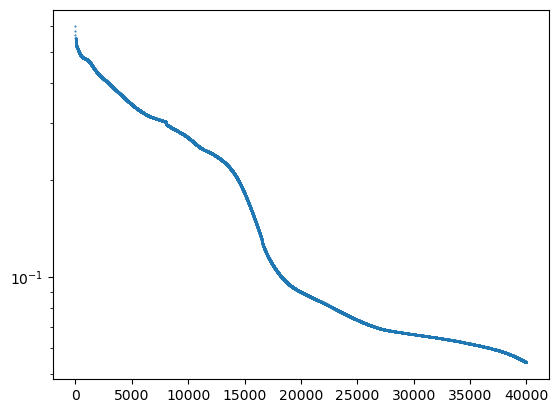

In [41]:
x = np.linspace(0,epoch,epoch)
plt.plot(x,loss_tracking,'o',markersize = 0.5)
plt.yscale('log')
plt.show()

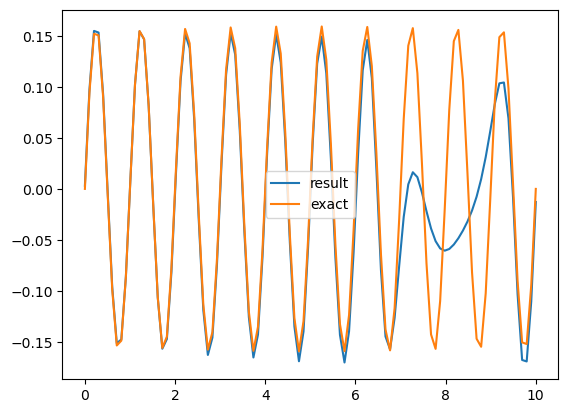

In [44]:
def exact(t):    
    u = (1/(2*np.pi))*torch.sin(2*np.pi*t)
    return u

test = torch.linspace(0,domain_muliple,100).unsqueeze(1)
result = net.forward(test).detach().numpy()

exactval = exact(test)

plt.plot(test,result,label = 'result')
plt.plot(test,exactval, label = 'exact')
plt.legend()
plt.show()

In [ ]:
# thing could be done to improve result

# domain decomposition
# give more weight to loss function as time increase